In [1]:
#Import required packages:
import sys
#print(sys.version)

from spectral import *
import spectral.io.envi as envi
import numpy as np
import matplotlib
#import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.use('WXAgg')
print('matplotlib backend:',matplotlib.get_backend())

matplotlib backend: WXAgg


In [3]:
img = envi.open('C:/Users/bhass/Desktop/RSDI/RSDI_2018/NEON_D02_SERC_DP3_368000_4306000_reflectance.hdr','C:/Users/bhass/Desktop/RSDI/RSDI_2018/NEON_D02_SERC_DP3_368000_4306000_reflectance.dat')

ImageView object:
  Display bands       :  (58, 34, 19)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0057999999999999996, 0.14710000000000001]
    G: [0.0184, 0.13300000000000001]
    B: [0.0086, 0.1099]



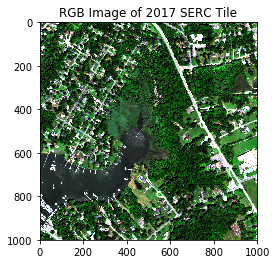

In [4]:
#plots appear below cells
%matplotlib inline 
view = imshow(img,bands=(58,34,19),stretch=0.05,title="RGB Image of 2017 SERC Tile")
print(view)

#TO DO: Assign UTM x,y to show geolocation

In [5]:
#Display metadata contents
md = img.metadata
print('Metadata Contents:\n')
for item in md:
    print(item)

#print('\nWavelengths:',md['wavelength'])
print('\nNumber of Bands:',len(md['wavelength']))

Metadata Contents:

description
samples
lines
bands
data type
interleave
file type
header offset
byte order
map info
coordinate system string
wavelength
fwhm
wavelength units
reflectance scale factor
data ignore value
dataset names

Number of Bands: 426


In [6]:
#Subset image by area & valid bands (remove water vapor bands & last 10 bands)
#This will make it faster to run classification algorithms for demonstration purposes. 

valid_band_range = [i for j in (range(0,191), range(212, 281), range(315,415)) for i in j]
print('# of valid bands:',len(valid_band_range))
img_subset = img.read_subimage(range(400,600),range(400,600),bands=valid_band_range)

# of valid bands: 360


In [7]:
type(md['wavelength'])
#for i in md['wavelength'] float(md['wavelength'])
wavelength_center_bands = np.array(list(map(float, md['wavelength'])))
print('total # of bands:',len(wavelength_center_bands))
wavelength_center_bands_valid = wavelength_center_bands[np.r_[0:191,212:281,315:415]]
print('# of valid bands:',len(wavelength_center_bands_valid))

total # of bands: 426
# of valid bands: 360


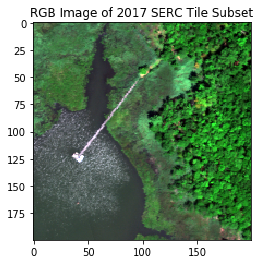

In [8]:
#Plot subsetted image
view = imshow(img_subset,bands=(58,34,19),stretch=0.001,title="RGB Image of 2017 SERC Tile Subset")

The `kmeans` algorithm takes an iterative approach to generating clusters. The parameter `k` specifies the desired number of clusters to generate. The algorithm begins with an initial set of cluster centers (e.g., results from cluster). Each pixel in the image is then assigned to the nearest cluster center (using distance in N-space as the distance metric) and each cluster center is then recomputed as the centroid of all pixels assigned to the cluster. This process repeats until a desired stopping criterion is reached (e.g., max number of iterations). 

In [9]:
(m,c) = kmeans(img_subset,5,50) #5 classes, up to 50 iterations (may terminate before this #)

Initializing clusters along diagonal of N-dimensional bounding box.
Iteration 1...  0.Iteration 1...27267 pixels reassigned.
Iteration 2...  0.Iteration 2...3969 pixels reassigned.
Iteration 3...  0.Iteration 3...1690 pixels reassigned.
Iteration 4...  0.Iteration 4...1141 pixels reassigned.
Iteration 5...  0.Iteration 5...811 pixels reassigned.
Iteration 6...  0.Iteration 6...440 pixels reassigned.
Iteration 7...  0.Iteration 7...236 pixels reassigned.
Iteration 8...  0.Iteration 8...143 pixels reassigned.
Iteration 9...  0.Iteration 9...87 pixels reassigned.
Iteration 10...  0.0Iteration 10...46 pixels reassigned.
Iteration 11...  0.0Iteration 11...20 pixels reassigned.
Iteration 12...  0.0Iteration 12...5 pixels reassigned.
Iteration 13...  0.0Iteration 13...2 pixels reassigned.
Iteration 14...  0.0Iteration 14...1 pixels reassigned.
Iteration 15...  0.0Iteration 15...0 pixels reassigned.
kmeans terminated with 5 clusters after 14 iterations.


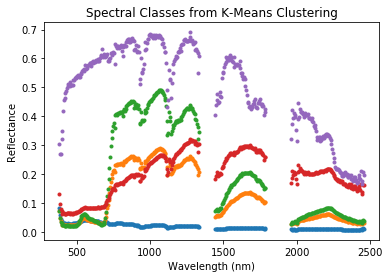

In [10]:
import pylab
pylab.figure()
pylab.hold(1)
for i in range(c.shape[0]):
    pylab.plot(wavelength_center_bands_valid,c[i],'.')
pylab.show
pylab.title('Spectral Classes from K-Means Clustering')
#pylab.xlabel('Band (with water vapor windows removed)')
pylab.xlabel('Wavelength (nm)')
pylab.ylabel('Reflectance')
#pylab.colorbar?

In [11]:
print('m:',m.shape)
print('c:',c.shape)

m: (200, 200)
c: (5, 360)


In [12]:
#define custom colors:
custom_colors = [(128,0,0),
         (128,128,0),
         (0,128,0),
         (0,128,128),
         (0,0,128)]

[(128, 0, 0), (128, 128, 0), (0, 128, 0), (0, 128, 128), (0, 0, 128)]

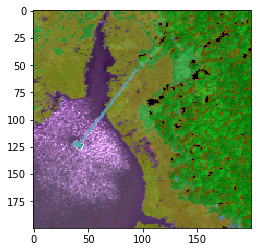

In [13]:
#view = imshow(img_subset,classes=m)
view = imshow(img_subset, bands=(58,34,19),stretch=0.01, classes=m,colors=custom_colors)
view.set_display_mode('overlay')
view.class_alpha = 0.8
view.show_data
view.class_colors

## Principal Component Analysis (PCA)
Many of the bands within hyperspectral images are often strongly correlated. The principal components transformation represents a linear transformation of the original image bands to a set of new, uncorrelated features. These new features correspond to the eigenvectors of the image covariance matrix, where the associated eigenvalue represents the variance in the direction of the eigenvector. A very large percentage of the image variance can be captured in a relatively small number of principal components (compared to the original number of bands) .

The `SPy` function `principal_components` computes the principal components of the image data and returns the mean, covariance, eigenvalues, and eigenvectors in a `PrincipalComponents` object. This object also contains a transform to rotate data in to the space of the principal compenents, as well as a method to reduce the number of eigenvectors.

Often it is useful to reduce the number of features by selecting only the most important ones that are still representative of the entire dataset. This is called **Dimensionality Reduction**. One such technique for reducing dimensionality is **Principal Component Analysis (PCA)**, which uses the variance of each feature to maximize its separability. PCA finds a low-dimension set of axes that summarize the data. Often times features are redundant, so we want to describe a data set with only unique (non-redundant) features. PCA doesn't select certain features and discard others; it constructs a new set of properties based on combinations of the old ones. Mathematically, PCA performs a linear transformation moving the original set of features to a new space composed by principal component. 

https://towardsdatascience.com/dimensionality-reduction-does-pca-really-improve-classification-outcome-6e9ba21f0a32

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

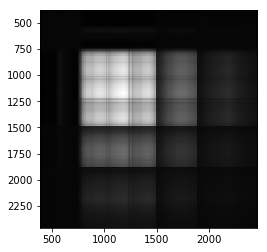

In [14]:
#Principal Component Analysis (PCA)
pc = principal_components(img_subset)
ext = (np.amin(wavelength_center_bands_valid),np.amax(wavelength_center_bands_valid),np.amax(wavelength_center_bands_valid),np.amin(wavelength_center_bands_valid))
pc_view = imshow(pc.cov,extent=ext)
xdata = pc.transform(img_subset)

1st 5 Eigenvalues: [  3.55759409e+00   8.48055263e-02   9.33189606e-03   2.92938263e-03]


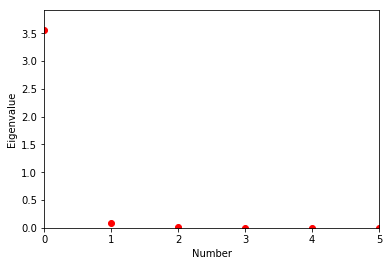

In [15]:
#Plot 1st 5 Eigenvalues
from matplotlib import pyplot as plt
plt.plot(pc.eigenvalues,'ro')
plt.ylabel('Eigenvalue'); plt.xlabel('Number')
plt.axis([0,5,0,max(pc.eigenvalues)*1.1])
print('1st 5 Eigenvalues:',pc.eigenvalues[:4])
#pc.eigenvectors

In the covariance matrix display, lighter values indicate strong positive covariance, darker values indicate strong negative covariance, and grey values indicate covariance near zero. We can see in this example that most of the covariance occurs betwen bands 50-200, which corresponds to wavelengths __ to __ nm.

To reduce dimensionality using principal components, we can sort the eigenvalues in descending order and then retain enough eigenvalues (and corresponding eigenvectors) to capture a desired fraction of the total image variance. We then reduce the dimensionality of the image pixels by projecting them onto the remaining eigenvectors. We will choose to retain a minimum of 99.9% of the total image variance.

How many eigenvalues are left? 5


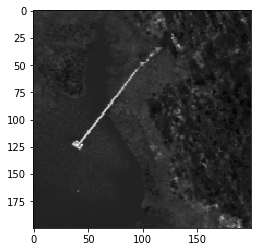

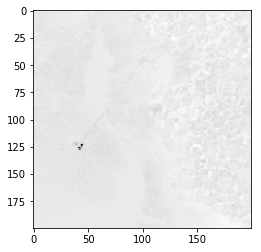

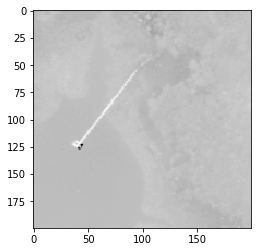

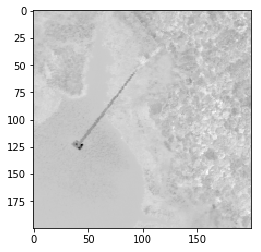

In [16]:
pc_0999 = pc.reduce(fraction=0.999)
print('How many eigenvalues are left?',len(pc_0999.eigenvalues))
img_pc = pc_0999.transform(img_subset)
v=imshow(img_pc[:,:,1],stretch_all=True) #,colors=custom_colors)
v=imshow(img_pc[:,:,2],stretch_all=True)
v=imshow(img_pc[:,:,3],stretch_all=True)
v=imshow(img_pc[:,:,4],stretch_all=True)
#v.class_colors

How many eigenvalues are left? 35


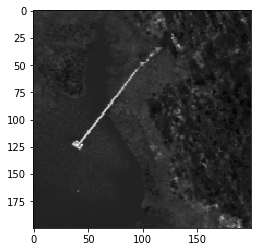

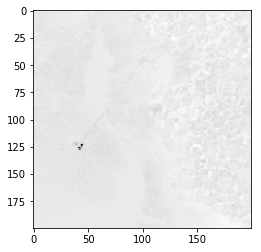

In [17]:
pc_09999 = pc.reduce(fraction=0.9999)
print('How many eigenvalues are left?',len(pc_09999.eigenvalues))
img_pc = pc_09999.transform(img_subset)
v=imshow(img_pc[:,:,1],stretch_all=True) #,colors=custom_colors)
v=imshow(img_pc[:,:,2],stretch_all=True)
#v=imshow(img_pc[:,:,3],stretch_all=True)
#v=imshow(img_pc[:,:,4],stretch_all=True)
#v.class_colors

In [18]:
print(img_pc.shape)
print(xdata.shape)
#img_pc[:,:,1].shape

(200, 200, 35)
(200, 200, 360)


In [ ]:
#N-Dimensional Feature Display (http://www.spectralpython.net/graphics.html)
w = view_nd(xdata[:,:,:3])

Now that we have used PCA to reduce the dimensionality of this hyperspectral data, let's try k-means unsupervised classification again:

In [19]:
(m_pca,c_pca) = kmeans(img_pc,5,50) 

Initializing clusters along diagonal of N-dimensional bounding box.
Iteration 1...  0.Iteration 1...40000 pixels reassigned.
Iteration 2...  0.Iteration 2...4656 pixels reassigned.
Iteration 3...  0.Iteration 3...5010 pixels reassigned.
Iteration 4...  0.Iteration 4...3969 pixels reassigned.
Iteration 5...  0.Iteration 5...2875 pixels reassigned.
Iteration 6...  0.Iteration 6...1851 pixels reassigned.
Iteration 7...  0.Iteration 7...1120 pixels reassigned.
Iteration 8...  0.Iteration 8...658 pixels reassigned.
Iteration 9...  0.Iteration 9...403 pixels reassigned.
Iteration 10...  0.0Iteration 10...236 pixels reassigned.
Iteration 11...  0.0Iteration 11...148 pixels reassigned.
Iteration 12...  0.0Iteration 12...87 pixels reassigned.
Iteration 13...  0.0Iteration 13...44 pixels reassigned.
Iteration 14...  0.0Iteration 14...25 pixels reassigned.
Iteration 15...  0.0Iteration 15...15 pixels reassigned.
Iteration 16...  0.0Iteration 16...7 pixels reassigned.
Iteration 17...  0.0Iteration

In [20]:
print(m_pca.shape)
print(c_pca.shape)
print(xdata.shape)

(200, 200)
(5, 35)
(200, 200, 360)


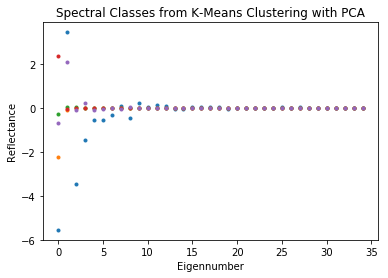

In [21]:
pylab.figure()
pylab.hold(1)
for i in range(c_pca.shape[0]):
    pylab.plot(c_pca[i],'.')
pylab.show
pylab.title('Spectral Classes from K-Means Clustering with PCA')
#pylab.xlabel('Band (with water vapor windows removed)')
pylab.xlabel('Eigennumber')
pylab.ylabel('Reflectance')
#pylab.colorbar?

[(128, 0, 0), (128, 128, 0), (0, 128, 0), (0, 128, 128), (0, 0, 128)]

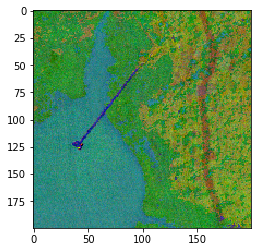

In [22]:
#view = imshow(img_subset,classes=m)
view = imshow(xdata, bands=(58,34,19),stretch=0.01, classes=m_pca,colors=custom_colors)
view.set_display_mode('overlay')
view.class_alpha = 0.8
view.show_data
view.class_colors
#view.set_classes

In [ ]:
#Look at classification differences with and without PCA:
print(m_pca)
print(m)

In [23]:
import copy
m_pca2 = copy.copy(m_pca)
# reclassification    
m_pca2[np.where(m_pca2 == 0)] = 5
m_pca2[np.where(m_pca2 == 1)] = 6
m_pca2[np.where(m_pca2 == 2)] = 7
m_pca2[np.where(m_pca2 == 3)] = 8
m_pca2[np.where(m_pca2 == 4)] = 9
print(m_pca2)

m2 = copy.copy(m)
# reclassification    
m2[np.where(m2 == 4)] = 5
m2[np.where(m2 == 2)] = 6
m2[np.where(m2 == 1)] = 7
m2[np.where(m2 == 0)] = 8
m2[np.where(m2 == 3)] = 9
print(m2)

[[7 7 7 ..., 7 6 6]
 [7 7 7 ..., 7 7 6]
 [7 7 7 ..., 8 7 6]
 ..., 
 [8 8 8 ..., 6 6 6]
 [8 8 8 ..., 6 6 6]
 [8 8 8 ..., 6 6 6]]
[[7 7 7 ..., 7 6 6]
 [7 7 7 ..., 7 7 6]
 [7 7 7 ..., 8 7 6]
 ..., 
 [8 8 8 ..., 6 6 6]
 [8 8 8 ..., 6 6 6]
 [8 8 8 ..., 6 6 6]]


In [31]:
m_diff = m2-m_pca2;
np.amax(m_diff)
np.amin(m_diff)
#imshow(m_diff,colors=custom_colors)
#view = imshow(xdata, bands=(58,34,19),stretch=0.01, classes=m_diff,colors=custom_colors)

0

In [ ]:
np.where(m_pca == 0)
m_pca[123,44]
m[123,44]
#print(m_pca[123,45])
#print(m[123,45])

In [ ]:
w = view_nd(xdata[:,:,:3])

In [ ]:
#!{sys.executable} -m pip install PyOpenGL